In [1]:
# Importing Libraries

import matplotlib.pyplot as plt
import pandas as pd
from statsbombpy import sb
from mplsoccer import Pitch, VerticalPitch, FontManager, Sbopen

In [3]:
# Open the data and assign it to 'df'dataframe
parser = Sbopen()
# Selecting the 2020-21 La Liga Season
df = parser.match(competition_id=11, season_id=90) #2020-21 Season
#df = parser.match(competition_id=11, season_id=26) #2014-15 Season
#df = parser.match(competition_id=11, season_id=1)  #2017-18 Season

In [4]:
team = "Barcelona"

# Get list of games by Barcelona, either home or away
match_ids = df.loc[(df["home_team_name"] == team) | (df["away_team_name"] == team)]["match_id"].tolist()

# Calculate number of games
no_games = len(match_ids)

In [5]:
# Declaring an empty dataframe for danger passes
danger_passes = pd.DataFrame()
for idx in match_ids:
    # Opening the event data for this match
    df = parser.event(idx)[0]
    for period in [1, 2]:
        # Keeping only accurate passes by Messi that were not set pieces in this period
        mask_pass = (df.player_id == 5503) & (df.type_name == "Pass") & (df.outcome_name.isnull()) & (df.period == period) & (df.sub_type_name.isnull())
        # Keeping necessary columns
        passes = df.loc[mask_pass, ["x", "y", "end_x", "end_y", "minute", "second", "player_id"]]
        # Keeping only Shots by Barcelona in this period
        mask_shot = (df.player_id == 5503) & (df.type_name == "Shot") & (df.period == period)
        # Keeping necessary columns
        shots = df.loc[mask_shot, ["minute", "second"]]
        # Converting time to seconds
        shot_times = shots['minute']*60+shots['second']
        shot_window = 15
        # Finding the start of the window
        shot_start = shot_times - shot_window
        # Condition to avoid negative shot starts
        shot_start = shot_start.apply(lambda i: i if i>0 else (period-1)*45)
        # Converting to seconds
        pass_times = passes['minute']*60+passes['second']
        # Checking if pass is in any of the windows for this half
        pass_to_shot = pass_times.apply(lambda x: True in ((shot_start < x) & (x < shot_times)).unique())

        # Keeping only danger passes
        danger_passes_period = passes.loc[pass_to_shot]
        # Concatenating dataframe with a previous one to keep danger passes from the whole season
        danger_passes = pd.concat([danger_passes, danger_passes_period], ignore_index = True)

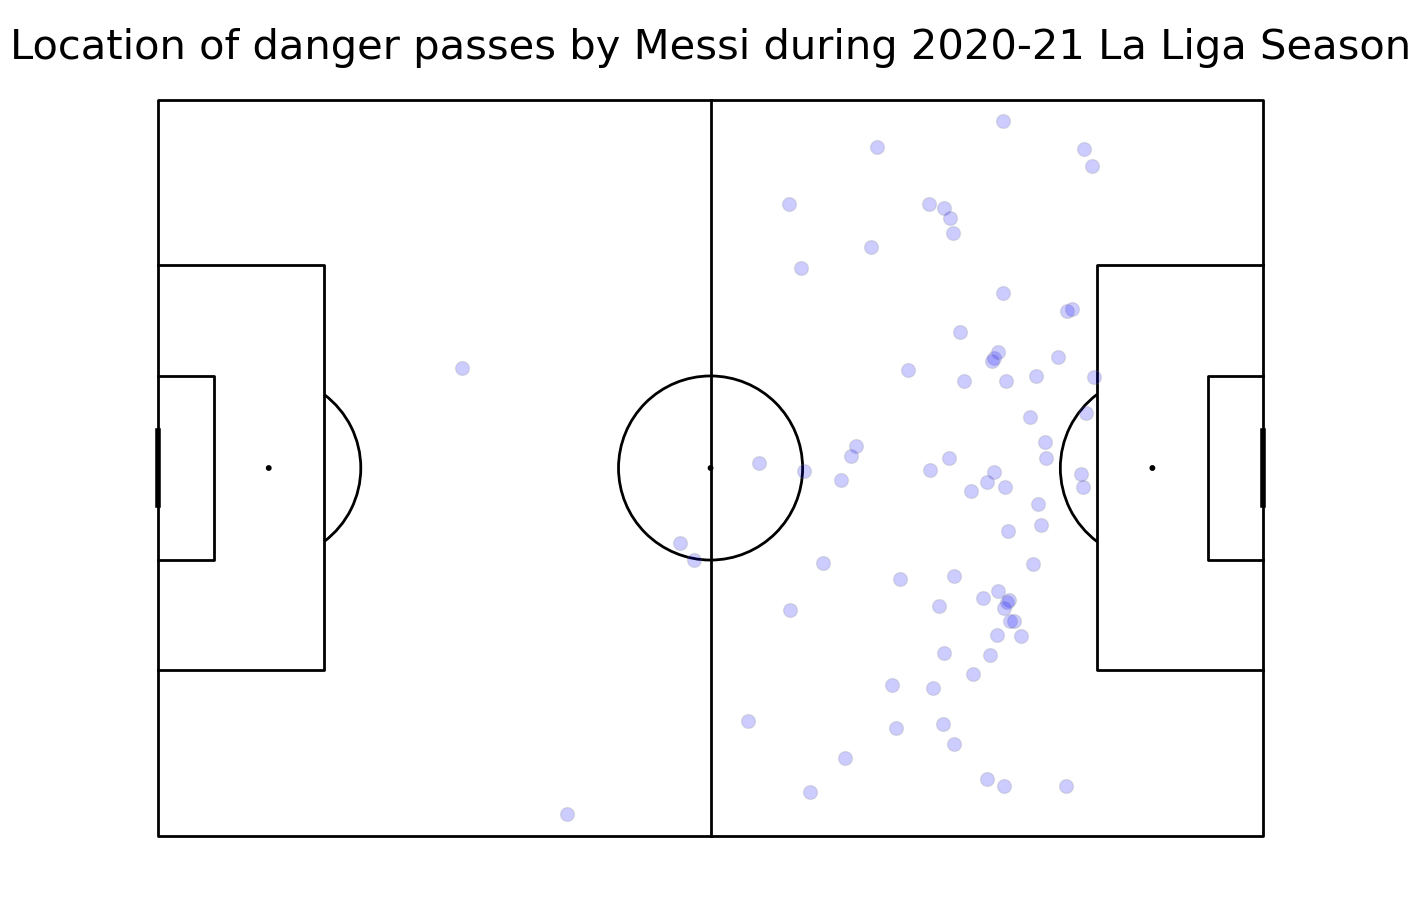

In [6]:
# Plotting pitch
pitch = Pitch(line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
# Plotting danger pass locations on the pitch
pitch.scatter(danger_passes.x, danger_passes.y, s=100, color='blue', edgecolors='grey', linewidth=1, alpha=0.2, ax=ax["pitch"])

# Title
fig.suptitle('Location of danger passes by Messi during 2020-21 La Liga Season', fontsize = 30) #Replace '2020-21' with '2014-15' or '2017-18' if you are using data from those seasons 
plt.show()

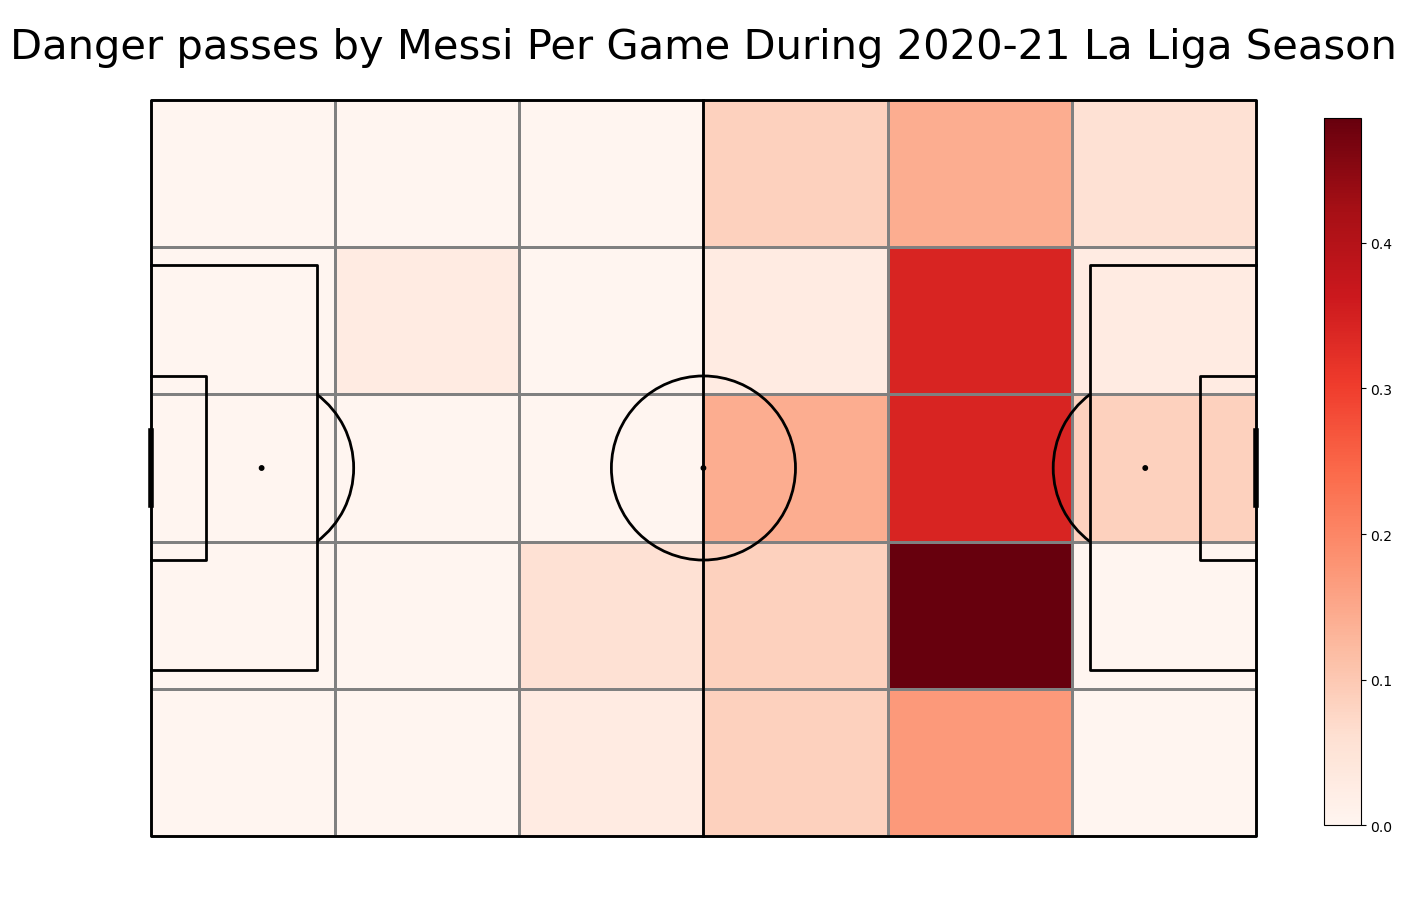

In [7]:
# Plotting vertical pitch
pitch = Pitch(line_zorder=2, line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
# Getting the 2D histogram
bin_statistic = pitch.bin_statistic(danger_passes.x, danger_passes.y, statistic='count', bins=(6, 5), normalize=False)
# Normalize by number of games
bin_statistic["statistic"] = bin_statistic["statistic"]/no_games
# Making a heatmap
pcm  = pitch.heatmap(bin_statistic, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
# Adding a legend and subtitle
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Danger passes by Messi' + " Per Game During 2020-21 La Liga Season", fontsize = 30) #Replace '2020-21' with '2014-15' or '2017-18' if you are using data from those seasons 
plt.show()